In [1]:
import matplotlib.pyplot as plt
import cv2
from utils import MOT_data_load
from utils import Visualization
import logging
import math
import numpy as np

In [2]:
Image, Detection, Tracklet = MOT_data_load.MOT17DataLoad('/home/yongchao/Dataset/MOT17-02-SDP')

INFO:root:ImagePath: /home/yongchao/Dataset/MOT17-02-SDP/img1, DetPath: /home/yongchao/Dataset/MOT17-02-SDP/det/det.txt, GtPath: /home/yongchao/Dataset/MOT17-02-SDP/gt/gt.txt
INFO:root:Read 99 images from /home/yongchao/Dataset/MOT17-02-SDP/img1
INFO:root:Read 99 frame detection
INFO:root:Read 83 tracklet


In [3]:
MaxDist = 50

## Cost function define

In [4]:
def CostFromSize(Size, SizeAvg):
    SizeCost = 1 - abs(SizeAvg[0]-Size[0])/(2*SizeAvg[0]+Size[0])-abs(SizeAvg[1]-Size[1])/(2*SizeAvg[1]+Size[1])
    #logging.info('Cost of Size: %f', SizeCost);
    return SizeCost;

In [5]:
def CostFromAppearance(BB, BBLast):
    BBhsv = cv2.cvtColor(BB, cv2.COLOR_BGR2HSV)
    BBLasthsv = cv2.cvtColor(BBLast, cv2.COLOR_BGR2HSV)
    
    Channel = [0, 1]
    bins=[180,256]
    ranged=[0,180,0,256]
    BBhist = cv2.calcHist([BBhsv], Channel,None, bins, ranged)
    BBLasthist = cv2.calcHist([BBLasthsv], Channel,None, bins, ranged)
    
    cv2.normalize(BBhist,BBhist,0,1,cv2.NORM_MINMAX)
    cv2.normalize(BBLasthist,BBLasthist,0,1,cv2.NORM_MINMAX)
    
    res = cv2.compareHist(BBhist,BBLasthist,cv2.cv.CV_COMP_CORREL)
    return res

In [6]:
def CostFromDistance(Center, CenterAvg):
    DisCost = (Center[0]-CenterAvg[0])*(Center[0]-CenterAvg[0]) + (Center[1]-CenterAvg[1])*(Center[1]-CenterAvg[1]);
    DisCost = DisCost/(2 * MaxDist * MaxDist)
    #logging.info('Cost of Distance: %f', DisCost);
    return DisCost

## predict function

In [7]:
def motionPredict(position, positionLast):
    delat_pos = position - positionLast;
    return delat_pos

In [8]:
def appearancePredict(size, sizeLast):
    sizeGain_x = size[0]/sizeLast[0]
    sizeGain_y = size[1]/sizeLast[1]
    return [sizeGain_x, sizeGain_y]

## visualization function

In [9]:
def visualizationBoundingboxs(image, boundingboxs):
    imageShow = image.copy()
    Red = (255, 0, 0)
    for index, boundbox in enumerate(boundingboxs):
        cv2.rectangle(imageShow, (int(math.floor(boundbox[0])), int(math.floor(boundbox[1]))), (int(math.floor(boundbox[0]))+int(math.floor(boundbox[2])), int(math.floor(boundbox[1]))+int(math.floor(boundbox[3]))), Red, 5)
        cv2.putText(imageShow, str(index), (int(math.floor(boundbox[0])), int(math.floor(boundbox[1]))), 2, 2, Red, 3)
    plt.figure(figsize=(20,20))
    plt.imshow(imageShow)
    plt.show()

## basic algorithm

In [10]:
INF = 99999999;
detectionNum = 4
match = np.ones(detectionNum)
match = match * -1;
ly = np.zeros(detectionNum)
lx = np.ones(detectionNum)
lx = lx * -1 * INF
slack = np.ones(detectionNum)
tracklet = np.zeros(detectionNum)
detection = np.zeros(detectionNum)
G = np.zeros((detectionNum,detectionNum))

In [11]:
def dataAssignToAlgo(costArray):
    costReform = [];
    for cost in costArray:
        totalCost = cost[2] + cost[3] + cost[4];
        totalCost = -totalCost;
        #print(totalCost)
        costReform.append([cost[0], cost[1], totalCost])
    return costReform

In [12]:
def KMAlgoInit(costReform):
    global lx
    global G
    G = np.zeros((detectionNum,detectionNum))
    for i in range(0, detectionNum):
        for j in range(0, detectionNum):
            for cost in costReform:
                if cost[0] == i and cost[1] == j:
                    G[i,j] = cost[2]
                    break;
    for i in range(0, detectionNum):
        for j in range(0, detectionNum):
            if lx[i] < G[i, j]:
                lx[i] = G[i, j]
    print(G)
    print(lx)

In [13]:
def KMAlgorithm():
    global tracklet
    global detection
    global slack;
    global match
    # this is for tracklet
    for i in range(0, detectionNum):
        slack = INF * slack;
        while True:
            tracklet = np.zeros(detectionNum)
            detection = np.zeros(detectionNum)
            if HungarianAlgorithm(i):
                break;
            d = INF;
            # this is for detection
            for j in range(0, detectionNum):
                if not tracklet[j]:
                    d = min(d, slack[j])

            for q in range(0, detectionNum):
                if detection[q]:
                    lx[q] -= d;
                if tracklet[q]:
                    ly[q] += d;
                else:
                    slack[q] -= d;
    print(match)

In [14]:
def HungarianAlgorithm(i):
    global tracklet
    global detection
    global slack;
    global match
    detection[i] = 1;
    
    for j in range(0, detectionNum):
        print(i,' Start to match ', j, 'Flag: ', tracklet[j])
        if tracklet[j] == 1:
            continue
        gap = lx[i] - G[i,j] -ly[j]
        print('gap: ', gap, 'lx: ',lx[i], 'G:', G[i,j], 'ly: ', ly[j])
        if gap == 0:
            tracklet[j] = 1;
            print('match[j]:', match[j])
            if match[j] == -1 or HungarianAlgorithm( match[j] ):
                match[j] = i;
                print(i, ' matched ', j)
                return True;
        else:
            slack[j] = min(slack[j], gap)
    return False;

## main function

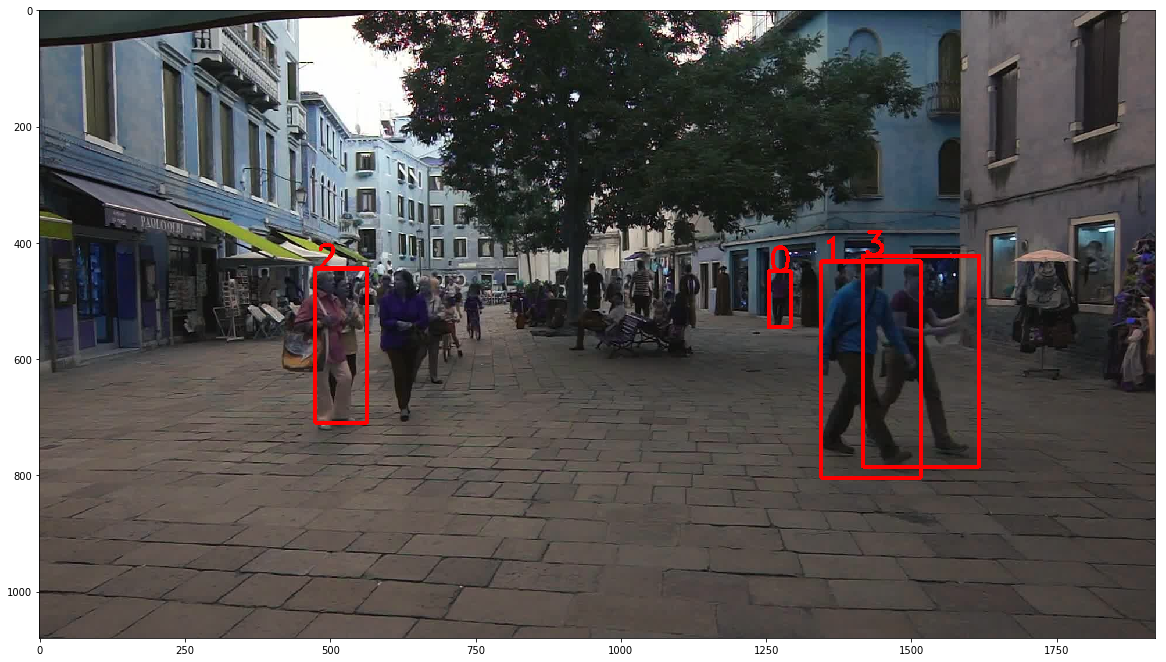

[[  -2.           -8.5128978  -115.70484587  -14.84291038]
 [  -8.16257029   -2.         -167.24521101   -3.29616842]
 [-115.53203106 -167.30324764   -2.         -199.93500509]
 [ -14.46955331   -3.29371552 -199.85749573   -2.        ]]
[-2. -2. -2. -2.]
(0, ' Start to match ', 0, 'Flag: ', 0.0)
('gap: ', 0.0, 'lx: ', -2.0, 'G:', -2.0, 'ly: ', 0.0)
('match[j]:', -1.0)
(0, ' matched ', 0)
(1, ' Start to match ', 0, 'Flag: ', 0.0)
('gap: ', 6.162570285087181, 'lx: ', -2.0, 'G:', -8.162570285087181, 'ly: ', 0.0)
(1, ' Start to match ', 1, 'Flag: ', 0.0)
('gap: ', 0.0, 'lx: ', -2.0, 'G:', -2.0, 'ly: ', 0.0)
('match[j]:', -1.0)
(1, ' matched ', 1)
(2, ' Start to match ', 0, 'Flag: ', 0.0)
('gap: ', 113.53203106152034, 'lx: ', -2.0, 'G:', -115.53203106152034, 'ly: ', 0.0)
(2, ' Start to match ', 1, 'Flag: ', 0.0)
('gap: ', 165.3032476406701, 'lx: ', -2.0, 'G:', -167.3032476406701, 'ly: ', 0.0)
(2, ' Start to match ', 2, 'Flag: ', 0.0)
('gap: ', 0.0, 'lx: ', -2.0, 'G:', -2.0, 'ly: ', 0.0)
('m

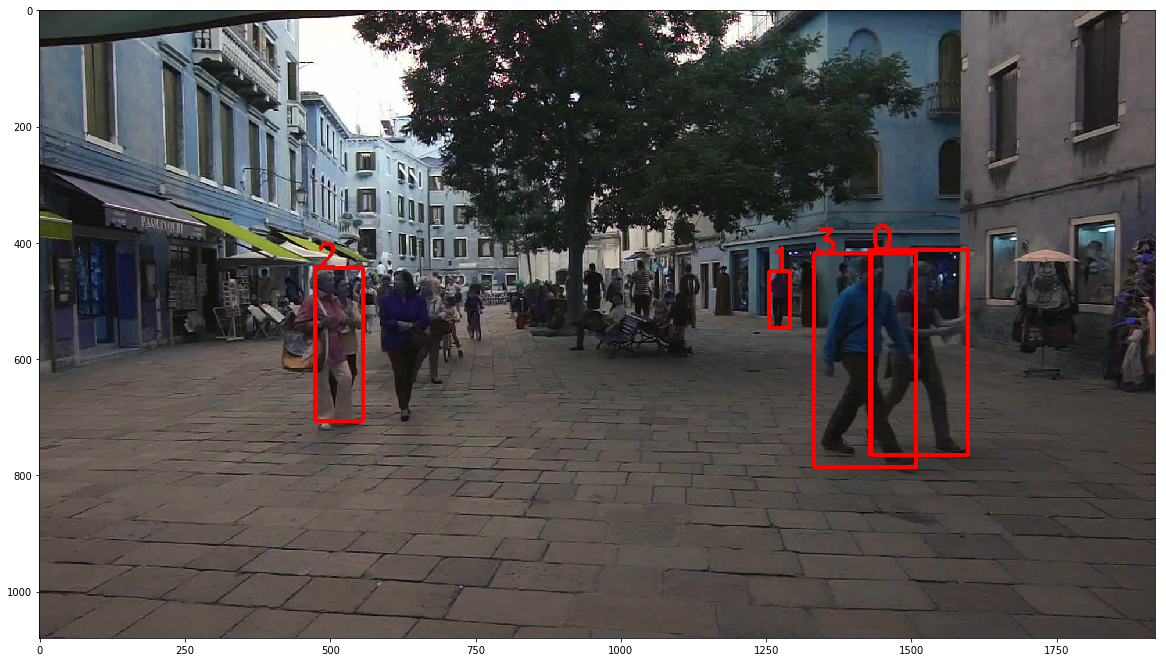

[[ -13.6271987    -3.25299749 -198.61320073   -1.84969664]
 [  -1.71069913   -8.47577758 -115.49468175  -14.81093153]
 [-116.56819689 -168.58293301   -1.7165734  -201.32469512]
 [  -6.82513663   -1.90209568 -163.3979382    -3.58597393]]
[-1.84969664 -1.71069913 -1.7165734  -1.90209568]
(0, ' Start to match ', 0, 'Flag: ', 0.0)
('gap: ', 11.777502061056204, 'lx: ', -1.8496966384693003, 'G:', -13.627198699525504, 'ly: ', 0.0)
(0, ' Start to match ', 1, 'Flag: ', 0.0)
('gap: ', 1.4033008483729619, 'lx: ', -1.8496966384693003, 'G:', -3.252997486842262, 'ly: ', 0.0)
(0, ' Start to match ', 2, 'Flag: ', 0.0)
('gap: ', 196.7635040919277, 'lx: ', -1.8496966384693003, 'G:', -198.613200730397, 'ly: ', 0.0)
(0, ' Start to match ', 3, 'Flag: ', 0.0)
('gap: ', 0.0, 'lx: ', -1.8496966384693003, 'G:', -1.8496966384693003, 'ly: ', 0.0)
('match[j]:', -1.0)
(0, ' matched ', 3)
(1, ' Start to match ', 0, 'Flag: ', 0.0)
('gap: ', 0.0, 'lx: ', -1.7106991335135167, 'G:', -1.7106991335135167, 'ly: ', 0.0)
('

In [15]:
frame = 0;
for image,detection in zip(Image, Detection):
    frame += 1
    if frame == 1:
        detectionLast = detection
        imageLast = image
    visualizationBoundingboxs(image, detection)
    match = np.ones(detectionNum)
    match = match * -1;
    
    TotalCost = []
    ## cost analysis
    for indexLast, detectLast in enumerate(detectionLast):
        for index, detect in enumerate(detection):
            # size cost function
            SizeLast = [detectLast[2], detectLast[3]];
            Size = [detect[2], detect[3]];
            SizeCost = CostFromSize(Size, SizeLast)
            # center position cost function
            CenterLast = [detectLast[0]+detectLast[2]/2, detectLast[1]+detectLast[3]/2];
            Center = [detect[0]+detect[2]/2, detect[1]+detect[3]/2];
            DisCost = CostFromDistance(Center, CenterLast)
            # Appearance cost function
            xLast_1 = int(math.floor(detectLast[0]));
            xLast_2 = int(math.floor(detectLast[0]+detectLast[2]));
            yLast_1 = int(math.floor(detectLast[1]));
            yLast_2 = int(math.floor(detectLast[1]+detectLast[3]));
            
            x_1 = int(math.floor(detect[0]));
            x_2 = int(math.floor(detect[0]+detect[2]));
            y_1 = int(math.floor(detect[1]));
            y_2 = int(math.floor(detect[1]+detect[3]));
            
            imgLastBoundingbox = imageLast[yLast_1:yLast_2, xLast_1:xLast_2];
            imgBoundingbox = image[y_1:y_2, x_1:x_2];
            AppearanceCost = CostFromAppearance(imgBoundingbox, imgLastBoundingbox)
            #plt.imshow(imgLastBoundingbox)
            #plt.imshow(imgBoundingbox)
            TotalCost.append([index, indexLast, SizeCost, DisCost, AppearanceCost])
    #print(TotalCost)
    detectionLast = detection;
    imageLast = image.copy();
    
    costReform = dataAssignToAlgo(TotalCost)
    KMAlgoInit(costReform)
    KMAlgorithm()
    
    if frame >= 2:
        break;